## Capstone Project: The Battle of Neighborhoods
### Week 5 - Final Assignment 

### Importing Libraries for Project


In [8]:
import numpy as np
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('expand_frame_repr', False)

import requests # library to handle requests
import urllib
import urllib.request
from urllib.request import urlopen
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from IPython.display import display
from IPython.core.display import HTML

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%pylab inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

print("Library Loaded")

Populating the interactive namespace from numpy and matplotlib
Library Loaded


### Dataset for Project

NYU neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

The data is slightly old, but available for free on the web. I downloaded the same from https://geo.nyu.edu/catalog/nyu_2451_34572 (nyu-2451-34572-geojson.json file). 

In [2]:
with open('nyu-2451-34572-geojson.json') as json_data:
    newyork_data = json.load(json_data)

### Transform data in DF

In [3]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print(neighborhoods.shape)    
print(neighborhoods.head())    

(306, 4)
  Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585


### Getting coordinated for New York City using geopy library

In [5]:
# Getting the coordinates for Toronto
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of the New York City are 40.7127281, -74.0060152.


### Filtering data for Manhattan

In [176]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
print(manhattan_data.shape)
manhattan_data.head()

(40, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


### Display Map of Manhattan with its neighborhood overlaid

In [7]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Borough'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

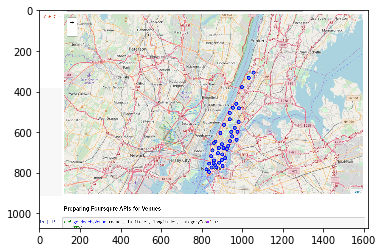

In [173]:
#Trying to somehow show the map in Github which is seen as in Jupyter
img=mpimg.imread('map_newyork.png')
imgplot = plt.imshow(img)
plt.show()

### Preparing Foursqure APIs for Venues

In [115]:
def getNearbyVenues(names, latitudes, longitudes, categoryIds=''):
    try:
        venues_list=[]
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)

            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)

            if (categoryIds != ''):
                url = url + '&categoryId={}'
                url = url.format(categoryIds)

            # make the GET request
            #print(url)
            response = requests.get(url).json()
            results = response["response"]['venues']

            # return only relevant information for each nearby venue
            for v in results:
                success = False
                try:
                    category = v['categories'][0]['name']
                    success = True
                except:
                    pass

                if success:
                    venues_list.append([(
                        name, 
                        lat, 
                        lng, 
                        v['name'], 
                        v['location']['lat'], 
                        v['location']['lng'],
                        v['categories'][0]['name']
                    )])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',  
                  'Venue Category']
    
    except:
        print(url)
        print(response)
        print(results)
        print(nearby_venues)

    return(nearby_venues)

In [123]:
LIMIT = 100 
radius = 1000 
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605'

In [124]:
#https://developer.foursquare.com/docs/resources/categories
#Bagel Shop = 4bf58dd8d48988d179941735
bagel_category = '4bf58dd8d48988d179941735'
neighborhoods = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
newyork_venues_bagel = getNearbyVenues(names=neighborhoods['Neighborhood'], latitudes=neighborhoods['Latitude'], longitudes=neighborhoods['Longitude'],categoryIds=bagel_category)
newyork_venues_bagel.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Cafeccino Bakery,40.880068,-73.907064,Bagel Shop
1,Marble Hill,40.876551,-73.91066,Token Bagel,40.885722,-73.910055,Bagel Shop
2,Marble Hill,40.876551,-73.91066,Gold Mine Cafe,40.878916,-73.904698,Café
3,Marble Hill,40.876551,-73.91066,Bagel Corner,40.885895,-73.910959,Bagel Shop
4,Marble Hill,40.876551,-73.91066,Mr. Bagel,40.880395,-73.903268,Bagel Shop


In [125]:
newyork_venues_bagel.shape

(575, 7)

In [163]:
newyork_venues_bagel

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.910660,Cafeccino Bakery,40.880068,-73.907064,Bagel Shop
1,Marble Hill,40.876551,-73.910660,Token Bagel,40.885722,-73.910055,Bagel Shop
2,Marble Hill,40.876551,-73.910660,Gold Mine Cafe,40.878916,-73.904698,Café
3,Marble Hill,40.876551,-73.910660,Bagel Corner,40.885895,-73.910959,Bagel Shop
4,Marble Hill,40.876551,-73.910660,Mr. Bagel,40.880395,-73.903268,Bagel Shop
5,Marble Hill,40.876551,-73.910660,Rolen Bagels,40.886624,-73.907168,Bagel Shop
6,Chinatown,40.715618,-73.994279,Bouchon's NYC,40.714120,-73.992771,Bagel Shop
7,Chinatown,40.715618,-73.994279,Kossar's Bialys,40.716400,-73.988800,Bagel Shop
8,Chinatown,40.715618,-73.994279,Lamar's Bagel Express,40.712498,-73.990115,Bagel Shop
9,Chinatown,40.715618,-73.994279,Davidovich Bakery,40.717871,-73.988257,Bagel Shop


### Adding venues to existing NY Map

In [126]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [127]:
map_newyork_bagel = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(newyork_venues_bagel, 'red', map_newyork_bagel)

map_newyork_bagel

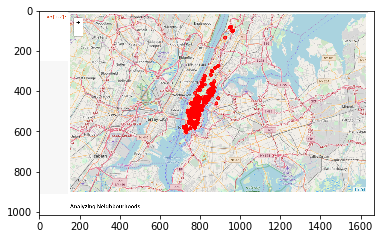

In [174]:
#Trying to somehow show the map in Github which is seen as in Jupyter
img=mpimg.imread('map_newyork_bagel.png')
imgplot = plt.imshow(img)
plt.show()

### Analyzing Neighbourhoods
- Grouping Venues by Neighborhood
- Analysing venues using one-hot encoding
- Clustering

In [128]:
def addColumn(startDf, columnTitle, dataDf):
    grouped = dataDf.groupby('Neighborhood').count()
    
    for n in startDf['Neighborhood']:
        try:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = grouped.loc[n, 'Venue']
        except:
            startDf.loc[startDf['Neighborhood'] == n,columnTitle] = 0

In [129]:
manhattan_grouped = newyork_venues_bagel.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(newyork_venues_bagel['Venue Category'].unique())))
print(newyork_venues_bagel['Venue Category'].unique())
print(manhattan_grouped['Venue'])

There are 15 uniques categories.
['Bagel Shop' 'Café' 'Gourmet Shop' 'Deli / Bodega' 'Donut Shop' 'Bakery'
 'Food Truck' 'Sandwich Place' 'Breakfast Spot' 'Bookstore' 'Salad Place'
 'Turkish Restaurant' 'Greek Restaurant' 'Corporate Amenity' 'Coffee Shop']
Neighborhood
Battery Park City       8
Carnegie Hill          20
Central Harlem          4
Chelsea                18
Chinatown              13
Civic Center           13
Clinton                18
East Harlem             6
East Village           18
Financial District      9
Flatiron               34
Gramercy               29
Greenwich Village      18
Hamilton Heights        2
Hudson Yards           14
Inwood                  1
Lenox Hill             18
Lincoln Square         12
Little Italy           15
Lower East Side        11
Manhattan Valley        5
Manhattanville          3
Marble Hill             6
Midtown                33
Midtown South          34
Morningside Heights     5
Murray Hill            30
Noho                   16
Ro

In [130]:
# one hot encoding
manhattan_onehot = pd.get_dummies(newyork_venues_bagel[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = newyork_venues_bagel['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot

,Neighborhood,Bagel Shop,Bakery,Bookstore,Breakfast Spot,Café,Coffee Shop,Corporate Amenity,Deli / Bodega,Donut Shop,Food Truck,Gourmet Shop,Greek Restaurant,Salad Place,Sandwich Place,Turkish Restaurant
0,Marble Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Marble Hill,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Marble Hill,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Chinatown,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Chinatown,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Chinatown,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Chinatown,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [164]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
print(manhattan_grouped.shape)
#print(len(manhattan_grouped[manhattan_grouped['Bagel Shop'] > 0]))
manhattan_grouped

(39, 16)


,Neighborhood,Bagel Shop,Bakery,Bookstore,Breakfast Spot,Café,Coffee Shop,Corporate Amenity,Deli / Bodega,Donut Shop,Food Truck,Gourmet Shop,Greek Restaurant,Salad Place,Sandwich Place,Turkish Restaurant
0,Battery Park City,0.750000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Carnegie Hill,0.750000,0.100000,0.000000,0.000000,0.050000,0.000000,0.000000,0.050000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Central Harlem,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Chelsea,0.722222,0.000000,0.000000,0.000000,0.055556,0.055556,0.000000,0.055556,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000
4,Chinatown,0.846154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000
5,Civic Center,0.769231,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000
6,Clinton,0.722222,0.055556,0.055556,0.055556,0.055556,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000
7,East Harlem,0.666667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000
8,East Village,0.944444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.000000,0.000000,0.000000
9,Financial District,0.777778,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000


In [165]:
manhattan_bagelshop = manhattan_grouped[["Neighborhood","Bagel Shop"]]
manhattan_bagelshop

,Neighborhood,Bagel Shop
0,Battery Park City,0.750000
1,Carnegie Hill,0.750000
2,Central Harlem,0.750000
3,Chelsea,0.722222
4,Chinatown,0.846154
5,Civic Center,0.769231
6,Clinton,0.722222
7,East Harlem,0.666667
8,East Village,0.944444
9,Financial District,0.777778


In [166]:
# set number of clusters
kclusters = 3

manhattan_bagelshop_clusters = manhattan_bagelshop.drop(["Neighborhood"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_bagelshop_clusters)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 2, 1, 1, 1, 0, 1])

In [167]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
manhattan_bagelshop_merged = manhattan_bagelshop.copy()

# add clustering labels
manhattan_bagelshop_merged["Cluster Labels"] = kmeans.labels_
manhattan_bagelshop_merged.head()

,Neighborhood,Bagel Shop,Cluster Labels
0,Battery Park City,0.750000,1
1,Carnegie Hill,0.750000,1
2,Central Harlem,0.750000,1
3,Chelsea,0.722222,1
4,Chinatown,0.846154,2


In [168]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_bagelshop_merged = manhattan_bagelshop_merged.join(manhattan_data.set_index("Neighborhood"), on="Neighborhood", how="inner")
manhattan_bagelshop_merged.sort_values(["Cluster Labels"], inplace=True)
print(manhattan_bagelshop_merged.shape)
manhattan_bagelshop_merged 

(39, 6)


,Neighborhood,Bagel Shop,Cluster Labels,Borough,Latitude,Longitude
19,Lower East Side,0.909091,0,Manhattan,40.717807,-73.980890
32,Tribeca,0.909091,0,Manhattan,40.721522,-74.010683
30,Stuyvesant Town,0.909091,0,Manhattan,40.731000,-73.974052
27,Noho,0.937500,0,Manhattan,40.723259,-73.988434
8,East Village,0.944444,0,Manhattan,40.727847,-73.982226
20,Manhattan Valley,1.000000,0,Manhattan,40.797307,-73.964286
17,Lincoln Square,0.916667,0,Manhattan,40.773529,-73.985338
13,Hamilton Heights,1.000000,0,Manhattan,40.823604,-73.949688
15,Inwood,1.000000,0,Manhattan,40.867684,-73.921210
33,Tudor City,0.764706,1,Manhattan,40.746917,-73.971219


In [169]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_bagelshop_merged['Latitude'], manhattan_bagelshop_merged['Longitude'], manhattan_bagelshop_merged['Neighborhood'], manhattan_bagelshop_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


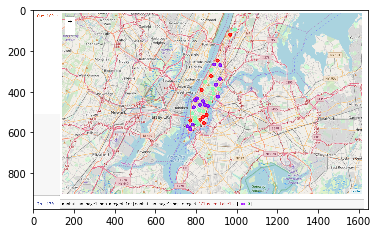

In [175]:
#Trying to somehow show the map in Github which is seen as in Jupyter
img=mpimg.imread('map_clusters.png')
imgplot = plt.imshow(img)
plt.show()

In [170]:
manhattan_bagelshop_merged.loc[manhattan_bagelshop_merged['Cluster Labels'] == 0]

,Neighborhood,Bagel Shop,Cluster Labels,Borough,Latitude,Longitude
19,Lower East Side,0.909091,0,Manhattan,40.717807,-73.980890
32,Tribeca,0.909091,0,Manhattan,40.721522,-74.010683
30,Stuyvesant Town,0.909091,0,Manhattan,40.731000,-73.974052
27,Noho,0.937500,0,Manhattan,40.723259,-73.988434
8,East Village,0.944444,0,Manhattan,40.727847,-73.982226
20,Manhattan Valley,1.000000,0,Manhattan,40.797307,-73.964286
17,Lincoln Square,0.916667,0,Manhattan,40.773529,-73.985338
13,Hamilton Heights,1.000000,0,Manhattan,40.823604,-73.949688
15,Inwood,1.000000,0,Manhattan,40.867684,-73.921210


In [171]:
manhattan_bagelshop_merged.loc[manhattan_bagelshop_merged['Cluster Labels'] == 1]

,Neighborhood,Bagel Shop,Cluster Labels,Borough,Latitude,Longitude
33,Tudor City,0.764706,1,Manhattan,40.746917,-73.971219
28,Roosevelt Island,0.727273,1,Manhattan,40.762160,-73.949168
26,Murray Hill,0.733333,1,Manhattan,40.748303,-73.978332
24,Midtown South,0.705882,1,Manhattan,40.748510,-73.988713
23,Midtown,0.696970,1,Manhattan,40.754691,-73.981669
21,Manhattanville,0.666667,1,Manhattan,40.816934,-73.957385
0,Battery Park City,0.750000,1,Manhattan,40.711932,-74.016869
5,Civic Center,0.769231,1,Manhattan,40.715229,-74.005415
1,Carnegie Hill,0.750000,1,Manhattan,40.782683,-73.953256
2,Central Harlem,0.750000,1,Manhattan,40.815976,-73.943211


In [172]:
manhattan_bagelshop_merged.loc[manhattan_bagelshop_merged['Cluster Labels'] == 2]

,Neighborhood,Bagel Shop,Cluster Labels,Borough,Latitude,Longitude
36,Upper West Side,0.846154,2,Manhattan,40.787658,-73.977059
35,Upper East Side,0.823529,2,Manhattan,40.775639,-73.960508
34,Turtle Bay,0.866667,2,Manhattan,40.752042,-73.967708
31,Sutton Place,0.888889,2,Manhattan,40.760280,-73.963556
29,Soho,0.818182,2,Manhattan,40.722184,-74.000657
16,Lenox Hill,0.833333,2,Manhattan,40.768113,-73.958860
25,Morningside Heights,0.800000,2,Manhattan,40.808000,-73.963896
22,Marble Hill,0.833333,2,Manhattan,40.876551,-73.910660
10,Flatiron,0.794118,2,Manhattan,40.739673,-73.990947
11,Gramercy,0.827586,2,Manhattan,40.737210,-73.981376
